In [6]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import deeplake


# Load the dataset
train_ds = deeplake.load('hub://activeloop/fer2013-train')
public_test_ds = deeplake.load('hub://activeloop/fer2013-public-test')

# Create DataLoaders
train_loader = train_ds.pytorch(num_workers=0, batch_size=64, shuffle=True)
public_test_loader = public_test_ds.pytorch(
    num_workers=0, batch_size=64, shuffle=False)

|

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fer2013-train



-

hub://activeloop/fer2013-train loaded successfully.



/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fer2013-public-test



|

hub://activeloop/fer2013-public-test loaded successfully.



In [7]:
# Define the model
class EmotionNet(nn.Module):
    def __init__(self):
        super(EmotionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*12*12, 128)  # Adjusted for smaller image size
        self.fc2 = nn.Linear(128, 7)  # 7 emotions

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = x.view(-1, 64*12*12)  # Adjusted for smaller image size
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x


model = EmotionNet()

# Move the model to CPU (default if no GPU is available)
device = torch.device('cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Training the model
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for batch in train_loader:
        images = batch['images'].float() / 255.0  # Normalize images
        labels = batch['labels'].squeeze().long()
        images = images.unsqueeze(1)  # Add channel dimension
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    print(f'Epoch {
          epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

Epoch 1/15, Loss: 1.6443, Train Accuracy: 35.33%
Epoch 2/15, Loss: 1.4546, Train Accuracy: 44.13%
Epoch 3/15, Loss: 1.3383, Train Accuracy: 48.89%
Epoch 4/15, Loss: 1.2549, Train Accuracy: 52.59%
Epoch 5/15, Loss: 1.1783, Train Accuracy: 55.90%
Epoch 6/15, Loss: 1.1082, Train Accuracy: 58.55%
Epoch 7/15, Loss: 1.0311, Train Accuracy: 61.74%
Epoch 8/15, Loss: 0.9608, Train Accuracy: 64.72%
Epoch 9/15, Loss: 0.8778, Train Accuracy: 67.93%
Epoch 10/15, Loss: 0.8109, Train Accuracy: 70.51%
Epoch 11/15, Loss: 0.7417, Train Accuracy: 73.13%
Epoch 12/15, Loss: 0.6585, Train Accuracy: 76.49%
Epoch 13/15, Loss: 0.5861, Train Accuracy: 79.32%
Epoch 14/15, Loss: 0.5180, Train Accuracy: 81.85%
Epoch 15/15, Loss: 0.4589, Train Accuracy: 83.93%


In [9]:
# Evaluating the model
# Define the emotion label mapping
emotion_map = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Evaluate the model and store the predictions
model.eval()
true_labels = []
predicted_labels = []
images_list = []
correct = 0
total = 0

with torch.no_grad():
    for batch in public_test_loader:
        # Unpack images and labels from the batch
        # Convert to float and normalize
        images = batch['images'].float() / 255.0
        labels = batch['labels'].squeeze().long()  # Ensuring labels are 1D
        # Reshape images to have 1 channel
        images = images.unsqueeze(1)  # Add channel dimension
        # Move tensors to CPU (default)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Store true labels, predicted labels, and images
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        images_list.extend(images.cpu().numpy())

accuracy = 100 * correct / total
print(f'Public Test Accuracy: {accuracy:.2f}%')

Public Test Accuracy: 50.74%


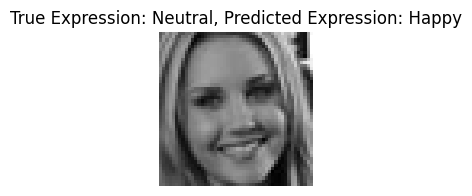

In [31]:
import random
import matplotlib.pyplot as plt

# Select a random index
random_idx = random.randint(0, len(images_list) - 1)

# Retrieve the image, true label, and predicted label
selected_image = images_list[random_idx][0]
selected_true_label = true_labels[random_idx]
selected_predicted_label = predicted_labels[random_idx]

# Convert integer labels to emotion expressions
true_label_expression = emotion_map[selected_true_label]
predicted_label_expression = emotion_map[selected_predicted_label]

# Plot the selected image
plt.figure(figsize=(2, 2))
plt.imshow(selected_image, cmap='gray')
plt.title(f'True Expression: {true_label_expression}, Predicted Expression: {
          predicted_label_expression}')
plt.axis('off')
plt.show()